## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

"wget" non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

Total rows in file: 1310720
We chose 660360 rows
        HEAD  FPGA  TDC_CHANNEL   ORBIT_CNT  BX_COUNTER  TDC_MEAS
0          1     0          123  3869200167        2374        26
1          1     0          124  3869200167        2374        27
2          1     0           63  3869200167        2553        28
3          1     0           64  3869200167        2558        19
4          1     0           64  3869200167        2760        25
...      ...   ...          ...         ...         ...       ...
660355     1     0           60  3869206700        1943         3
660356     1     0           37  3869206700        1944        17
660357     1     0           58  3869206700        1953        22
660358     1     0           61  3869206700        2089        22
660359     1     0           59  3869206700        2094        13

[660360 rows x 6 columns]
BX in a ORBIT = 3564
Data talking lasted 0.9804564 seconds
Absolute time (ns) =
0         3.447457e+14
1         3.447457e+14
2     

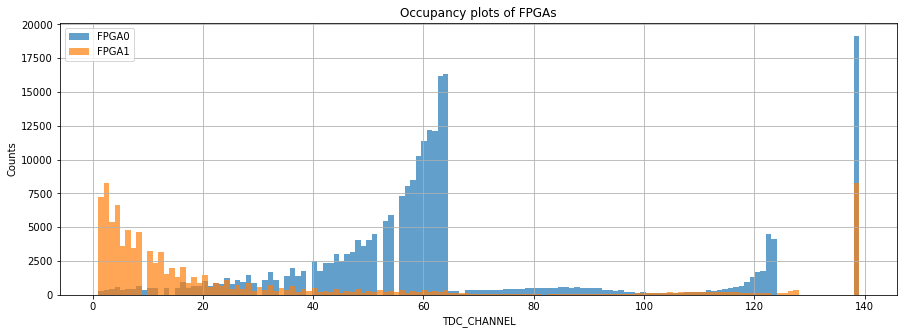

In [12]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import pandas as pd

filename = 'data_000637.txt'
# 1
try:
    with open(filename) as f:
        N_max = len(f.readlines()) - 1
except:
    print(f"Error: can't open {filename}")
print(f"Total rows in file: {N_max}")
assert(N_max > 10000)
N = int((N_max + 10000) / 2)
print(f"We chose {N} rows")
df = pd.read_csv(filename, sep=',', nrows=N)
print(df)
# 2
x = df["BX_COUNTER"].max() + 1
print(f"BX in a ORBIT = {x}")
# 3
df_all = pd.read_csv(filename, sep=',')
assert(df_all["TDC_MEAS"].max() <= 30)
data_talking = \
(df_all["ORBIT_CNT"].max() - df_all["ORBIT_CNT"].min()) * x * 25e-9
+ df_all["BX_COUNTER"].sum() * 25e-9
+ df_all["TDC_MEAS"] * 25/30*1e-9
print(f"Data talking lasted {data_talking} seconds")
# 4
# (Assuming we're considering first N rows)
time = df["ORBIT_CNT"] * x * 25 + df["BX_COUNTER"] * 25 + df["TDC_MEAS"] * 25/30
print("Absolute time (ns) =")
print(time)
# 5
rng = npr.default_rng()
df["HEAD"] = rng.integers(0, 2, df["HEAD"].shape[0], dtype=np.int)
# 6
df2 = df[df["HEAD"] == 1]
assert(df2["HEAD"].shape[0] == np.sum(df["HEAD"]))
# Assuming we're using new DataFrame from now on
df = df2
# 7
fpga0 = df[df["FPGA"] == 0]
fpga1 = df[df["FPGA"] == 1]
#print(fpga0); print(fpga1)
max_TDC = np.max(df["TDC_CHANNEL"])
print(f"Max value in TDC_CHANNEL: {max_TDC}")
min_TDC = np.min(df["TDC_CHANNEL"])
print(f"Min value in TDC_CHANNEL: {min_TDC}")
# We plot all values
plt.figure(figsize=(15,5))
alpha_value = 0.7
fpga0["TDC_CHANNEL"].hist(bins=np.max(fpga0["TDC_CHANNEL"]), alpha=alpha_value, label="FPGA0")
fpga1["TDC_CHANNEL"].hist(bins=np.max(fpga1["TDC_CHANNEL"]), alpha=alpha_value, label="FPGA1")
plt.legend()
plt.title("Occupancy plots of FPGAs")
plt.xlabel("TDC_CHANNEL")
plt.ylabel("Counts")
# 8
# We use "HEAD" columns to keep track of counting
noisy = (df.groupby(["TDC_CHANNEL"]).sum()).sort_values(by="HEAD", ascending=False)
print("Dataframe reordered by most noisy TDC channels")
print(noisy)
print("The first three noisy channels are:")
print(np.array(noisy.index[:3]))
# 9
unique = df["ORBIT_CNT"].unique()
print(f"Unique orbits ({unique.size} total):")
print(unique)
unique139 = df[df["TDC_CHANNEL"] == 139]["ORBIT_CNT"].unique()
print(f"Unique orbits from TDC_CHANNEL=139 ({unique139.size} total):")
print(unique139)